In [1]:
import importlib
import os
import random
import time

import import_ipynb
import numpy as np
import pandas as pnd
import requests
import seaborn as sns
from boardgamegeek import BoardGameGeek
from langdetect import detect
from tqdm.notebook import tqdm

import BggDbGetter as BDG
import BggDbScraper as BDS
import BggHelper as BH
import Cicero as Cic
import Glossa as glos

importing Jupyter notebook from BggDbGetter.ipynb
importing Jupyter notebook from BggDbScraper.ipynb
importing Jupyter notebook from BggHelper.ipynb
importing Jupyter notebook from Cicero.ipynb
importing Jupyter notebook from Glossa.ipynb


# Step 1

Access BBG API's to download game and user preferences data.
Define criterion used for setting the parameters that drive the download in termis of the variables defining the dataset, such collecting games only for a specified period or a specified set of categories. The wider the game collection, the better.

In [2]:
helper = BH.BggHelper()
new_df = helper.bgg_start(get=False, scrape=False)

#### Dataframe reading

In [3]:
df = pnd.read_csv("BGG_sampled.csv")
df.shape
dfh = df

In [4]:
gls = glos.Glossa(dfh, "en")
cicero = Cic.Cicero(gls)

In [5]:
cicero = cicero.clean_lemming("description")

Glossa.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "from tqdm.notebook import tqdm\n",


Glossa.ipynb:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "class Glossa:\n",
Glossa.ipynb:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "            word.replace(\"'\", \"\")\n",


In [6]:
cicero = cicero.clean_lemming("categories")

In [7]:
#cicero = cicero.eng_lemming("name")
cicero = cicero.eng_lemming("publishers")

In [8]:
cicero = cicero.eng_lemming("families")

In [9]:
cicero = cicero.eng_lemming("mechanics")
df["families"][0]

"['Campaign Games', 'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Dungeon Crawler', 'Gloomhaven Universe', 'Legacy', 'Player Count: Games with Solitaire Rules']"

In [10]:
year_tag_analysis = df[["name", "mechanics", "families", "yearpublished"]]#[0]
year_tag_analysis

,name,mechanics,families,yearpublished
0,Gloomhaven,"['Action Retrieval', 'Campaign / Battle Card D...","['Campaign Games', 'Components: Miniatures', '...",2017
1,Pandemic Legacy: Season 1,"['Action Points', 'Cooperative Game', 'Hand Ma...","['Campaign Games', 'Legacy', 'Pandemic', 'Them...",2015
2,Terraforming Mars,"['Card Drafting', 'End Game Bonuses', 'Hand Ma...","[""Fryxgames' Future Timeline"", 'Player Count: ...",2016
3,Brass: Birmingham,"['Connections', 'Hand Management', 'Income', '...","['Brass', 'Cities: Birmingham (England)', 'Cou...",2018
4,Through the Ages: A New Story of Civilization,"['Action Points', 'Auction/Bidding', 'Auction:...","['Tableau Building', 'Through the Ages']",2015
...,...,...,...,...
14110,Who Wants to Be a Millionaire,['Push Your Luck'],"['TV Series: TV Game Shows', 'TV Series: Who W...",2000
14111,In a Pickle,"['Hand Management', 'Storytelling']",['Gamewright Port-A-Party Series'],2004
14112,Fact or Crap,"['Card Drafting', 'Memory']",[],2001
14113,The Worst-Case Scenario Survival Game,['Dice Rolling'],['The Worst-Case Scenario Survival Family'],2002


In [11]:
"""for row in year_tag_analysis:
    row[]"""

'for row in year_tag_analysis:\n    row[]'

In [12]:
#year_tag_df = cicero.get_df()[]
#cicero.get_df()[cicero.get_df()["families"] == "[]"]

# Step 2

Pre-process game text (title and description) in order to define the terms to include in the variables to be observed, eventually using a word embedding model to normalize and/or expand the terminology extracted from the game description.

## Followed  this url:
### https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92


<div class="mark">
    TODO: Everything done until now is fine, yet there are some issues and here lies the solution
</div><i class="fa fa-lightbulb-o "></i>
<ul>
    <li>The corpus is made of N rows</li>
    <li>Each rows has a variable number of words M
        <ul>
            <li>Train W2V with overall corpus</li>
            <li>Extract from each row the top relevant words via Sklearn's TF-IDF</li>
            <li>Embed via W2V the top relevant words into a matrix of dimension XxD</li>
            <li>Use python's transfromer to compress them into a vector of dimension D'</li>
        </ul>
    </li>
    <li>Create a Neural network with input size XxD' and train it</li>
    <li>Find the correlation during testing time (remember to cross-validate)</li>
    <li>????</li>
    <li>Profit</li>
</ul>

#### Need to create a column in the dataframe containing all the important words in the row. <br> This takes into account Name, description, mechanics, families and publishers

In [13]:
df.columns

Index(['Unnamed: 0', 'boardgame_rank', 'id', 'families', 'categories',
       'mechanics', 'designers', 'artists', 'publishers', 'description',
       'yearpublished', 'minplayers', 'maxplayers', 'playingtime', 'minage',
       'name', 'usersrated', 'average', 'bayesaverage', 'stddev', 'owned',
       'numweights', 'averageweight', 'ranks'],
      dtype='object')

In [14]:
model, corpus = cicero.word2vec_train(["description", "mechanics", "categories", "families", "publishers"])

corpus

In [15]:
## Pass to Pitagora class text corpus and model
## Pitagora will return a vector of dimension D'

import Pitagora as ptg
import importlib

importlib.reload(ptg)
pitagora = ptg.Pitagora(corpus, model)

importing Jupyter notebook from Pitagora.ipynb
importing Jupyter notebook from Pitagora.ipynb


In [16]:
cps = pitagora.topwords_extraction(quantity=20)

In [17]:
j = 0
variables = cicero.get_df()
trainset = []
for element in tqdm(cps):
    trainset.append((element, variables.loc[j, [
        "name", "boardgame_rank", "averageweight", "average", "yearpublished",
        "playingtime", "minplayers", "maxplayers"
    ]]))
    j += 1
#variables.loc[j, ["name", "id"]][1]#[["name", "id"]]

In [18]:
#trainset[0]

(['action',
  'adventure',
  'campaign',
  'card',
  'cooperative',
  'determine',
  'dungeon',
  'game',
  'gloomhaven',
  'hand',
  'initiative',
  'legacy',
  'order',
  'play',
  'player',
  'playing',
  'power',
  'scenario',
  'turn',
  'world'],
 name              Gloomhaven
 boardgame_rank             1
 averageweight         3.8266
 average               8.8288
 yearpublished           2017
 playingtime              120
 minplayers                 1
 maxplayers                 4
 Name: 0, dtype: object)

In [19]:
embeddings = []
i = 0
quantity = 20

In [20]:
for element in tqdm(trainset):
    foster_element = []
    try:
        for word in element[0]:
            foster_element.append(model[word].tolist())
        if len(foster_element) < quantity:
            foster_element = []
        else:
            embeddings.append((foster_element, element[1]))
    except:
        print("Absent word: ", word, " - From game: ", element[1])
        i += 1
        pass

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Absent word:  abstratus  - From game:  name              Abstratus
boardgame_rank         9540
averageweight             1
average             8.33805
yearpublished          2018
playingtime              40
minplayers                2
maxplayers                4
Name: 6449, dtype: object
Absent word:  moneybags  - From game:  name              Moneybags
boardgame_rank        12169
averageweight           1.5
average             5.76381
yearpublished          2018
playingtime              30
minplayers                3
maxplayers                6
Name: 8096, dtype: object
Absent word:  esagek  - From game:  name               Esagek
boardgame_rank      12355
averageweight         2.5
average           6.42512
yearpublished        2006
playingtime            30
minplayers              1
maxplayers              6
Name: 8213, dtype: object
Absent word:  cubicup  - From game:  name              CubiCup
boardgame_rank      13505
averageweight      2.3333
average              6.15
yearpublish

In [21]:
len(embeddings), len(embeddings[0]), len(embeddings[0][0]), len(embeddings[0][0][0]), quantity ** 2

(11802, 2, 20, 100, 400)

### Once "embeddings" has been obtained, it must be compressed via a transformer
##### Each list contains 10 words, post embedding each word becomes a list of 100 values. 
100 values * 10 words = 1000 values <br>

Two possible paths: <br>
1] Neural network with 1000 neurons as input layers [OUT OF QUESTION]<br>
2] Compression of each 10 terms of 100 values each into one single vector of length D', in order to make an input layer of D' neurons [FEASIBLE WITH SKLEARN.DECOMPOSITION'S PCA IMPLEMENTATION]-> No! Use Autoencoder with NN! <br>



In [22]:
#%reload_ext autoreload
#%autoreload 2

import Athena
import importlib


importing Jupyter notebook from Athena.ipynb


Using TensorFlow backend.


In [23]:
importlib.reload(Athena)

importing Jupyter notebook from Athena.ipynb


<module 'Athena' from 'Athena.ipynb'>

In [24]:
model_rank = Athena.Athena(embeddings).make_model_rank().get_model_rank()

MAKE RANK!
Input layer:  2004
Metrics:  [<keras.metrics.MeanMetricWrapper object at 0x7ffac46bbf90>, <keras.metrics.MeanMetricWrapper object at 0x7ffac46bba90>, <keras.metrics.MeanMetricWrapper object at 0x7ffac46bb8d0>]


In [76]:
model_classic_vote = Athena.Athena(embeddings).make_model_classic().get_model_classic()

MAKE CLASSIC!
Input layer:  2004
Metrics:  [<keras.metrics.MeanMetricWrapper object at 0x7ffa7bf5b9d0>, <keras.metrics.MeanMetricWrapper object at 0x7ffa7bf5bc90>, <keras.metrics.MeanMetricWrapper object at 0x7ffa7bf735d0>]


In [74]:
model_classic_weight = Athena.Athena(embeddings).make_model_classic().get_model_classic()

MAKE CLASSIC!
Input layer:  2004
Metrics:  [<keras.metrics.MeanMetricWrapper object at 0x7ffa7bd254d0>, <keras.metrics.MeanMetricWrapper object at 0x7ffa7bd25710>, <keras.metrics.MeanMetricWrapper object at 0x7ffa7bd253d0>]


In [27]:
j = 0
x, x_elem = [], []#np.array([]), []
#y = np.array([])
y_rank, y_weight, y_vote = [], [], []
for i in tqdm(embeddings):
    #y = np.concatenate(y, np.array([i[1]]))
    #y.append(i[1][1:])
    y_rank.append(i[1][1])
    y_weight.append(i[1][2])
    y_vote.append(i[1][3])
    #change here from 20 to 10
    while j < 20:
        x_elem += i[0][j]
        j += 1
    #x = np.concatenate(x, np.array(x_elem))
    x_elem.append(i[1][4])
    x_elem.append(i[1][5])
    x_elem.append(i[1][6])
    x_elem.append(i[1][7])
    x.append(np.array(x_elem))
    x_elem = []
    j = 0
#i = embeddings[0][0]
#i

In [75]:
rankmax = max(y_rank)
y_rank = list(map(lambda y: y/rankmax, y_rank))
y_weight = list(map(lambda y: y*(1/5), y_weight))
y_vote = list(map(lambda y: y/10, y_vote))

In [89]:
len(y_vote), len(x)

(11802, 11802)

In [29]:
len(x), len(y_rank), len(embeddings)

(11802, 11802, 11802)

In [57]:
import Hephaestus

In [62]:
import extra_keras_metrics
import keras.utils
import numpy as np
import tensorflow as tf
from keras import backend as B
from keras.layers import BatchNormalization, Dense
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from matplotlib import pyplot as plt
from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from tqdm import tqdm_notebook as tqdm

In [56]:
importlib.reload(Hephaestus)

importing Jupyter notebook from Hephaestus.ipynb


<module 'Hephaestus' from 'Hephaestus.ipynb'>

In [58]:
hephaestus_rank = Hephaestus.Hephaestus(model_rank, x, y_rank)

In [59]:
histories_rank = hephaestus_rank.kfold_x_validation()

In [79]:
hephaestus_weight = Hephaestus.Hephaestus(model_classic_weight, x, y_weight)

In [80]:
histories_weight = hephaestus_weight.kfold_x_validation()

In [81]:
hephaestus_vote = Hephaestus.Hephaestus(model_classic_vote, x, y_vote)

In [82]:
histories_vote = hephaestus_vote.kfold_x_validation()

In [102]:
auc = np.array([0])
for parameter in histories_weight:
    auc = np.add(auc, parameter.history["auc_3"])
auc = np.divide(auc, 5)

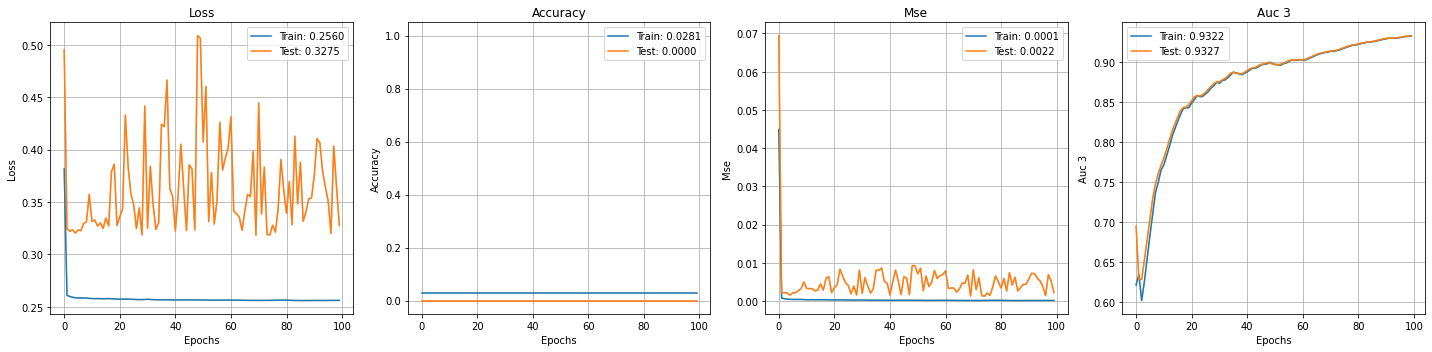

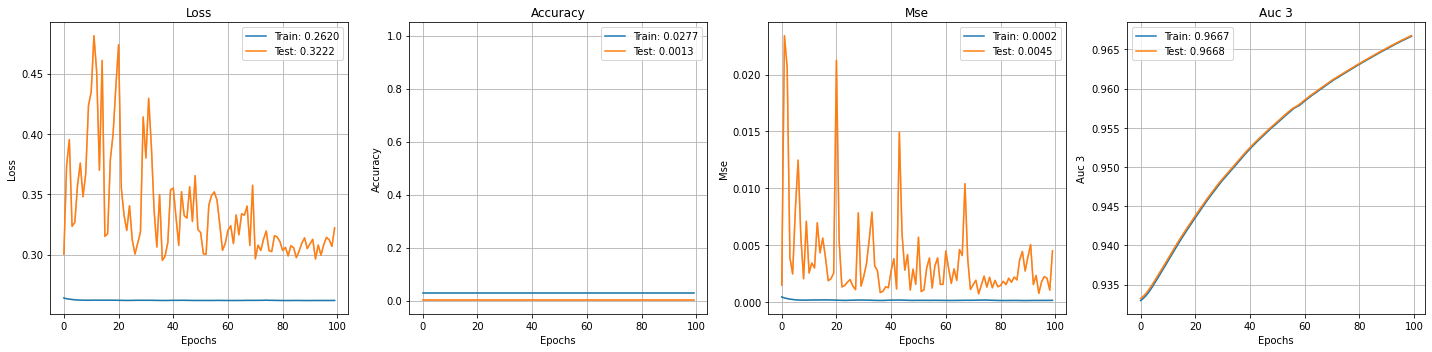

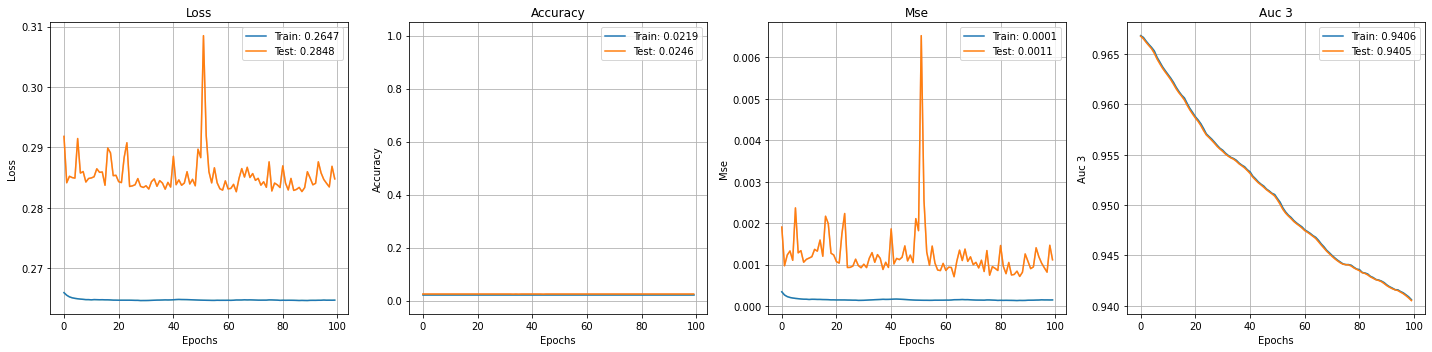

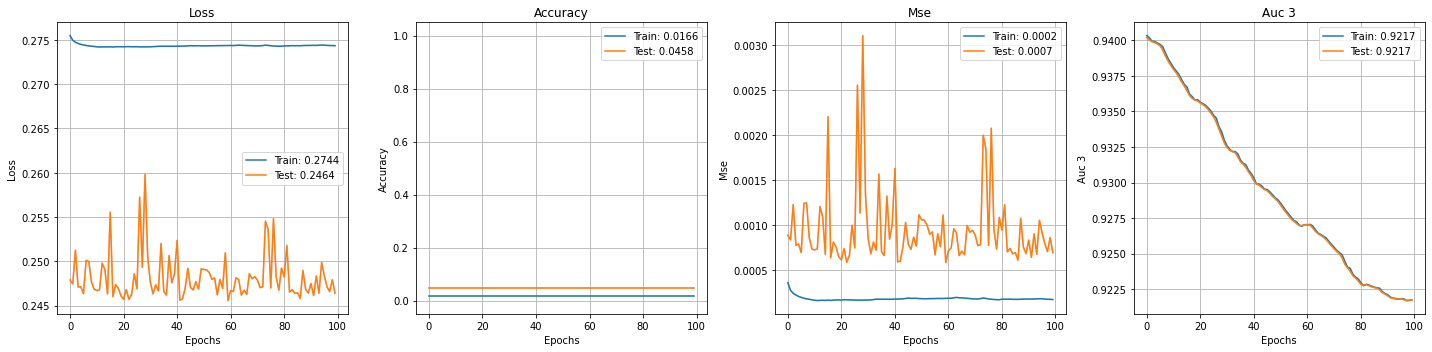

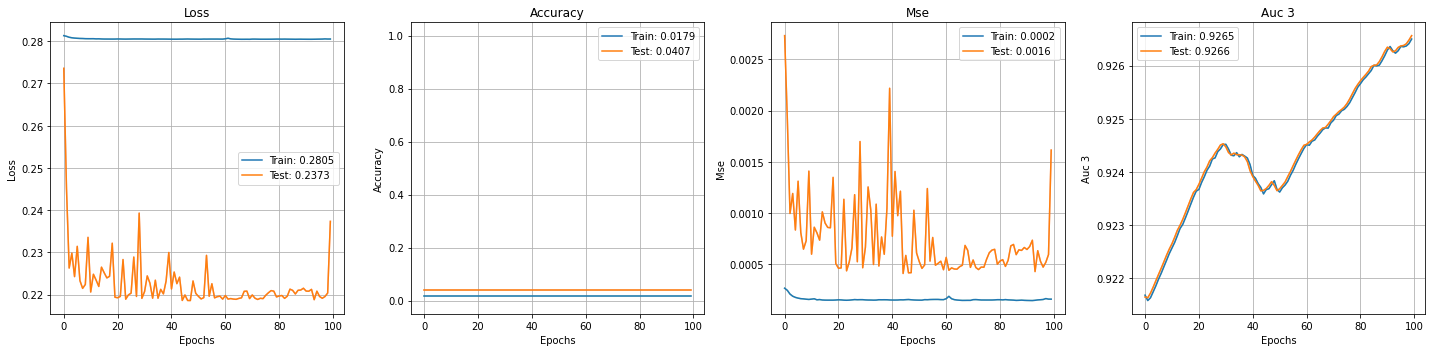

In [108]:
for i in histories_weight:
    plot_history(i.history)

In [101]:
np.divide(np.add(np.array([0]), np.array([1,2,3])), 2)

array([0.5, 1. , 1.5])

In [85]:
histories_vote[0].history

{'val_loss': [0.2676489392579612,
  0.27668735647605636,
  0.2719807572283987,
  0.27146747364836227,
  0.2687464306920262,
  0.27029895711753327,
  0.27008086796534264,
  0.26472872778520745,
  0.2675759298316503,
  0.2668847895274728,
  0.26792129066030856,
  0.2676538964449349,
  0.2723866687992872,
  0.2692423687142841,
  0.26978257510621667,
  0.27050802374290206,
  0.2703812968932976,
  0.26877247620437106,
  0.2705787848618071,
  0.2690789674298238,
  0.27201041175147234,
  0.2676893374677432,
  0.26822352500285135,
  0.26739104622501436,
  0.2726139951560457,
  0.26646437968237924,
  0.2731229280011129,
  0.26686458082522374,
  0.27185097053899604,
  0.2716938248125173,
  0.2654190066507307,
  0.2682945690922818,
  0.2654702113846601,
  0.2686137289313947,
  0.26629681900396185,
  0.2673818381155951,
  0.27114696805760014,
  0.2659238194004964,
  0.2715130579673638,
  0.27132240230754273,
  0.2720526350756823,
  0.2680207517187474,
  0.268296548168538,
  0.26676748687938107,
  

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


kf = KFold(n_splits=5)
kf.get_n_splits(x)

ranks_histories = []
x = np.array(x)
y_rank = np.array(y_rank)
for train_index, test_index in tqdm(kf.split(x)):
    x_rank_train, x_rank_test = x[train_index], x[test_index]
    y_rank_train, y_rank_test = y_rank[train_index], y_rank[test_index]
    history_rank = model_rank.fit(x_rank_train,
                      y_rank_train,
                      epochs=100,
                      shuffle=True,
                      batch_size=32,
                      verbose=0,
                      callbacks=[ktqdm(metric_format="{name}: {value:e}")],
                      validation_data=(x_rank_test, y_rank_test)
                     )
    ranks_histories.append(history_rank)

for history in ranks_histories:
    plot_history(history.history)

x_rank_train, x_rank_test, y_rank_train, y_rank_test = train_test_split(np.array(x),
                                                    np.array(y_rank), 
                                                    train_size=0.70, 
                                                    test_size=0.30)

x_w_train, x_w_test, y_w_train, y_w_test = train_test_split(np.array(x),
                                                    np.array(y_weigth), 
                                                    train_size=0.70, 
                                                    test_size=0.30)

x_v_train, x_v_test, y_v_train, y_v_test = train_test_split(np.array(x),
                                                    np.array(y_vote), 
                                                    train_size=0.70, 
                                                    test_size=0.30)

In [71]:
#np.shape(y_train)
#(x_train[0])
#(y_test)
#x_test, y_test

In [72]:
#model_2, model_3 = model.get_model(), model.get_model()

In [39]:
history_rank = model_rank.fit(x_rank_train,
                      y_rank_train,
                      epochs=100,
                      shuffle=True,
                      batch_size=32,
                      verbose=0,
                      callbacks=[ktqdm(metric_format="{name}: {value:e}")],
                      validation_data=(x_rank_test, y_rank_test)
                     )

In [40]:
history_weight = model_classic_weight.fit(x_w_train,
                      y_w_train,
                      epochs=100,
                      shuffle=True,
                      batch_size=32,
                      verbose=0,
                      callbacks=[ktqdm(metric_format="{name}: {value:e}")],
                      validation_data=(x_w_test, y_w_test)
                     )

In [41]:
history_vote = model_classic_vote.fit(x_v_train,
                      y_v_train,
                      epochs=100,
                      shuffle=True,
                      batch_size=32,
                      verbose=0,
                      callbacks=[ktqdm(metric_format="{name}: {value:e}")],
                      validation_data=(x_v_test, y_v_test)
                     )

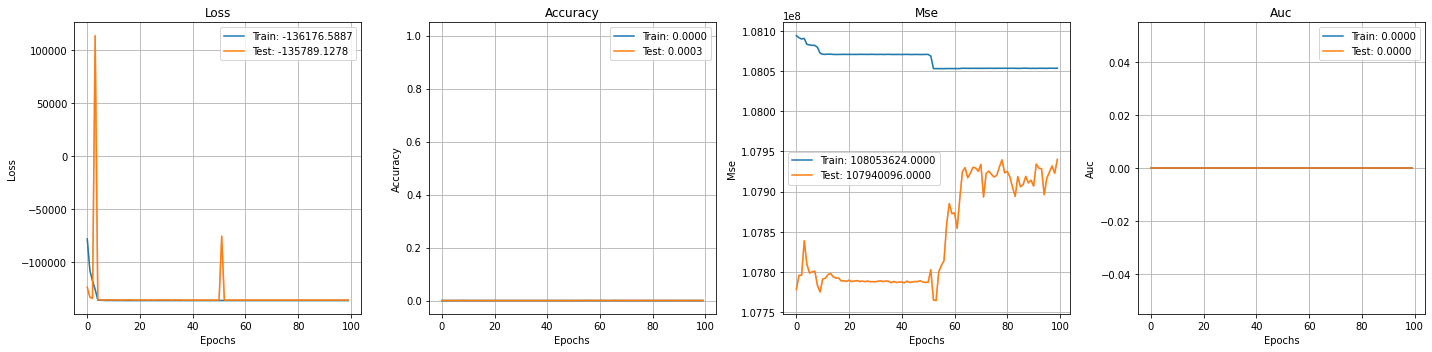

In [42]:
from plot_keras_history import plot_history

def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')

plot_history(history_rank.history)

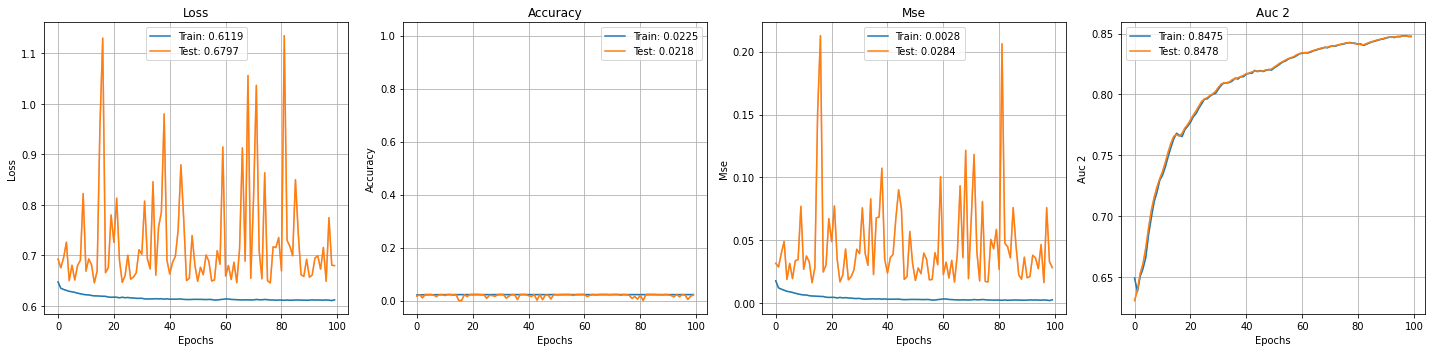

In [43]:
plot_history(history_weight.history)

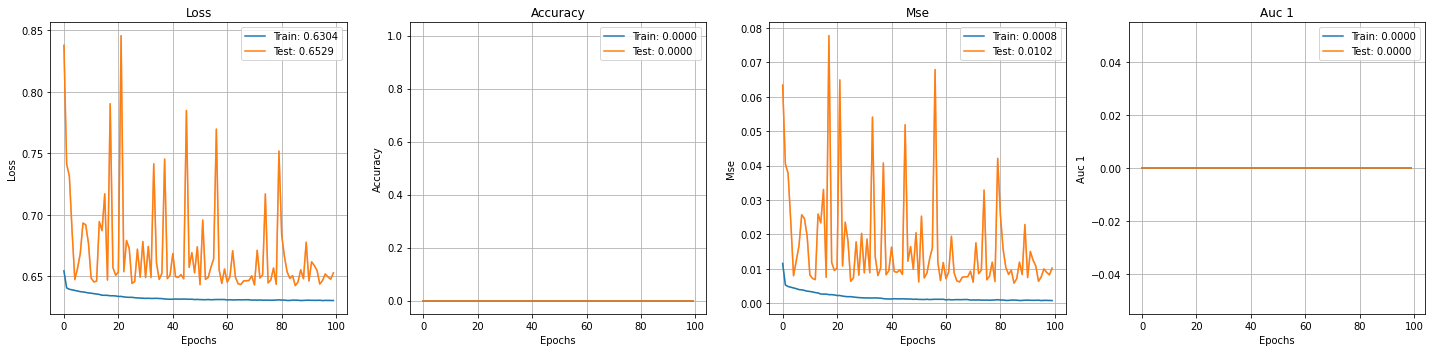

In [44]:
plot_history(history_vote.history)

In [45]:
#history = model.train_model(x_train[0], y_train[0], x_test[0], y_test[0])

## Step 3
Perform a correlation analysis of the variables. On top of this, try to design and implement a model for predicting the "subjective" variable values starting from the "objective" variables. Optionally, define a recommendation system for games.

## Variables to be observed:

<table style="width:100%">
  <tr>
    <th>Objective</th>
    <th>Subjective</th>
  </tr>
  <tr>
    <td>Name</td>
    <td>User rating</td>
  </tr>
  <tr>
    <td>Description</td>
    <td>Average</td>
  </tr>
  <tr>
    <td>Categories</td>
    <td>Average Weight</td>
  </tr>
  <tr>
    <td>Families</td>
    <td>Owned</td>
  </tr>
  <tr>
    <td>Publishers</td>
    <td>Rank</td>
  </tr>
  <tr>
    <td>Mechanics</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
  </tr>
</table>

 ##### Embeddings is shaped as a list of lists, each containing both the overall embeddings and the corresponding subjective informations about the game.
Each list contains a 100-dimensional list 

In [46]:
a = (cicero.get_df()["mechanics"][0]).strip("[").strip("]").split(",")
#.replace("'", "")
[x.replace("'", "").strip() for x in a]

['Action Retrieval',
 'Campaign / Battle Card Driven',
 'Communication Limits',
 'Cooperative Game',
 'Deck',
 'Bag',
 'and Pool Building',
 'Grid Movement',
 'Hand Management',
 'Legacy Game',
 'Modular Board',
 'Once-Per-Game Abilities',
 'Role Playing',
 'Scenario / Mission / Campaign Game',
 'Simultaneous Action Selection',
 'Solo / Solitaire Game',
 'Storytelling',
 'Variable Player Powers']

In [47]:
year_tag_analysis = year_tag_analysis[year_tag_analysis["mechanics"] != "[]"]
year_tag_analysis = year_tag_analysis[year_tag_analysis["families"] != "[]"]

In [48]:
mechanics_year_list = []
families_year_list = []
for index, row in tqdm(year_tag_analysis.iterrows()):
    mechanics_year_list += [(x.replace("'", "").replace("\"", "").strip().lower(), row["yearpublished"]) for x in ((row["mechanics"].strip("[").strip("]")).split(","))]
    families_year_list += [(x.replace("'", "").replace("\"", "").strip().lower(), row["yearpublished"]) for x in ((row["families"].strip("[").strip("]")).split(",")) if x.replace("'", "").replace("\"", "").strip().lower() != "admin: better description needed!"]
    

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
families_year_list

[('campaign games', 2017),
 ('components: miniatures', 2017),
 ('crowdfunding: kickstarter', 2017),
 ('dungeon crawler', 2017),
 ('gloomhaven universe', 2017),
 ('legacy', 2017),
 ('player count: games with solitaire rules', 2017),
 ('campaign games', 2015),
 ('legacy', 2015),
 ('pandemic', 2015),
 ('theme: diseases', 2015),
 ('fryxgames future timeline', 2016),
 ('player count: games with solitaire rules', 2016),
 ('space: earths solar system', 2016),
 ('space: mars', 2016),
 ('tableau building', 2016),
 ('terraforming mars', 2016),
 ('brass', 2018),
 ('cities: birmingham (england)', 2018),
 ('country: england', 2018),
 ('crowdfunding: kickstarter', 2018),
 ('history: industrial revolution', 2018),
 ('theme: beer', 2018),
 ('tableau building', 2015),
 ('through the ages', 2015),
 ('4x games', 2017),
 ('components: miniatures', 2017),
 ('twilight imperium', 2017),
 ('components: miniatures', 2016),
 ('movies: star wars', 2016),
 ('country: soviet union', 2005),
 ('country: usa', 2005),

In [50]:
set_mechs, set_fams = set(mechanics_year_list), set(families_year_list)
sorted_mechs, sorted_fams = sorted(mechanics_year_list), sorted(families_year_list)

In [51]:
years_mechs, years_fams = [], []
for i in range(2000, 2021):
    years_mechs.append(sorted([x for x in sorted_mechs if x[1] == i], key=lambda x: x[0], reverse=True))
    years_fams.append(sorted([x for x in sorted_fams if x[1] == i], key=lambda x: x[0], reverse=True))

In [52]:
freq_mechs_years, freq_fams_years = [], []
for year in years_mechs:
    set_year = set(year)
    freq_year = []
    for tag in set_year:
        #"{:.5%}".format
        freq_year += [(year.count(tag)/len(year), tag[0], tag[1])]
    freq_mechs_years.append(sorted(freq_year, key=lambda x: x[0], reverse=True))

In [53]:
for year in years_fams:
    set_year = set(year)
    freq_year = []
    for tag in set_year:
        #"{:.5%}".format
        freq_year += [(year.count(tag)/len(year), tag[0], tag[1])]
    freq_fams_years.append(sorted(freq_year, key=lambda x: x[0], reverse=True))

freq_fams_years[0][0][0]
sm = 0
for year in freq_fams_years[0]:
    sm += year[0]
print(sm)

In [54]:
topmost_by_year_mechs, topmost_by_year_fams = [], []
for year in freq_mechs_years:
    topmost_by_year_mechs.append(year[:10])
for year in freq_fams_years:
    topmost_by_year_fams.append(year[:10])

In [69]:
topmost_by_year_mechs

[[(0.09336099585062241, 'dice rolling', 2000),
  (0.08298755186721991, 'set collection', 2000),
  (0.07468879668049792, 'roll / spin and move', 2000),
  (0.06846473029045644, 'hand management', 2000),
  (0.06639004149377593, 'hexagon grid', 2000),
  (0.05186721991701245, 'auction/bidding', 2000),
  (0.04564315352697095, 'variable player powers', 2000),
  (0.03734439834024896, 'trading', 2000),
  (0.03112033195020747, 'tile placement', 2000),
  (0.026970954356846474, 'player elimination', 2000)],
 [(0.09327548806941431, 'dice rolling', 2001),
  (0.06724511930585683, 'hand management', 2001),
  (0.06724511930585683, 'set collection', 2001),
  (0.05856832971800434, 'hexagon grid', 2001),
  (0.05422993492407809, 'auction/bidding', 2001),
  (0.05422993492407809, 'tile placement', 2001),
  (0.052060737527114966, 'roll / spin and move', 2001),
  (0.0455531453362256, 'modular board', 2001),
  (0.03470715835140998, 'simulation', 2001),
  (0.03470715835140998, 'variable player powers', 2001)],
 

In [94]:
#topmost_by_year_fams

In [166]:
mechs_whole = []
fams_whole = []
for year in freq_mechs_years:
    mechs_whole += year
for year in freq_fams_years:
    fams_whole += year

In [169]:
all_mechs_names = []
all_fams_names = []
for year in topmost_by_year_mechs:
    for tag in year:
        all_mechs_names += [tag[1]]
for year in topmost_by_year_fams:
    for tag in year:
        all_fams_names += [tag[1]]
#set(all_mechs_names), set(all_fams_names)

In [174]:
## Every tuple <percentage, game name, year> in topmost_by_year_mechs / fams
## gets searched in the overall frequencies of all mechs  and / or fams in order
## to plot an overall trending graph for each one of them
growth_mechs = []
scanned = []
for year in topmost_by_year_mechs:
    for tag in year:
        stub = [x for x in mechs_whole if x not in scanned and x[1] == tag[1]]
        if stub not in scanned:
            growth_mechs.append(stub)
        scanned.append(stub)

In [178]:
growth_fams = []
schanned = []
for year in tqdm(topmost_by_year_fams):
    for tag in year:
        stub = [x for x in fams_whole if x not in scanned and x[1] == tag[1]]
        if stub not in scanned:
            growth_fams.append(stub)
        scanned.append(stub)

/home/tore/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [179]:
growth_fams

[[(0.030534351145038167, 'monopoly', 2000),
  (0.01876675603217158, 'monopoly', 2001),
  (0.009237875288683603, 'monopoly', 2002),
  (0.00980392156862745, 'monopoly', 2003),
  (0.0018148820326678765, 'monopoly', 2004),
  (0.013812154696132596, 'monopoly', 2005),
  (0.007836990595611285, 'monopoly', 2006),
  (0.005434782608695652, 'monopoly', 2007),
  (0.006544502617801047, 'monopoly', 2008),
  (0.00881057268722467, 'monopoly', 2009),
  (0.002803738317757009, 'monopoly', 2010),
  (0.0037313432835820895, 'monopoly', 2011),
  (0.00487408610885459, 'monopoly', 2012),
  (0.004205214465937763, 'monopoly', 2013),
  (0.0026542800265428003, 'monopoly', 2014),
  (0.003579952267303103, 'monopoly', 2015),
  (0.0017482517482517483, 'monopoly', 2016),
  (0.0005482456140350877, 'monopoly', 2017),
  (0.001632208922742111, 'monopoly', 2018),
  (0.0012586532410320957, 'monopoly', 2019)],
 [(0.022900763358778626, 'ccgs (collectible card games)', 2000),
  (0.01876675603217158, 'ccgs (collectible card game

In [161]:
bag_and_pool_building = []
for el in growth: 
    bag_and_pool_building += [(x[0], "bag and pool building", x[2]) for x in el if x[1] == "bag"]


In [162]:
bag_and_pool_building

[(0.002074688796680498, 'bag and pool building', 2000),
 (0.001876172607879925, 'bag and pool building', 2002),
 (0.0012531328320802004, 'bag and pool building', 2004),
 (0.0010570824524312897, 'bag and pool building', 2005),
 (0.001076426264800861, 'bag and pool building', 2007),
 (0.0019065776930409914, 'bag and pool building', 2008),
 (0.004792332268370607, 'bag and pool building', 2009),
 (0.007730147575544624, 'bag and pool building', 2010),
 (0.017004578155657292, 'bag and pool building', 2011),
 (0.016648168701442843, 'bag and pool building', 2012),
 (0.02330293819655522, 'bag and pool building', 2013),
 (0.02574416733708769, 'bag and pool building', 2014),
 (0.02321491382342596, 'bag and pool building', 2015),
 (0.027815934065934064, 'bag and pool building', 2016),
 (0.023655217109526897, 'bag and pool building', 2017),
 (0.025522755227552277, 'bag and pool building', 2018),
 (0.021083242457288258, 'bag and pool building', 2019)]

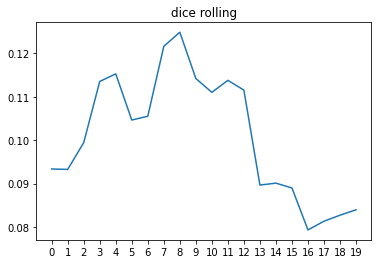

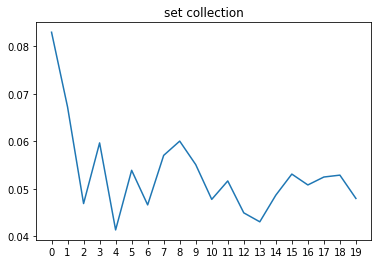

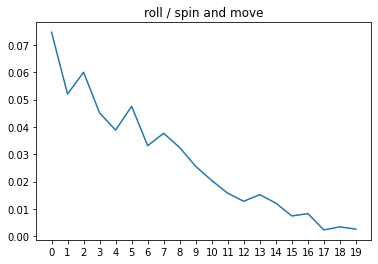

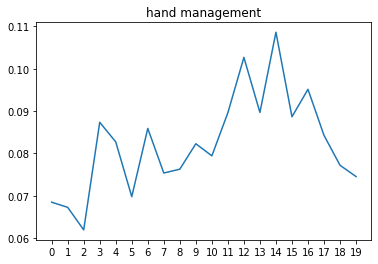

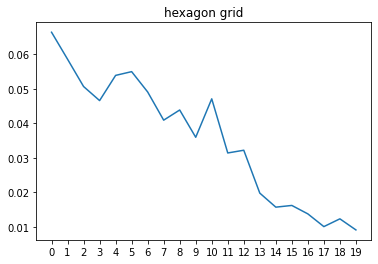

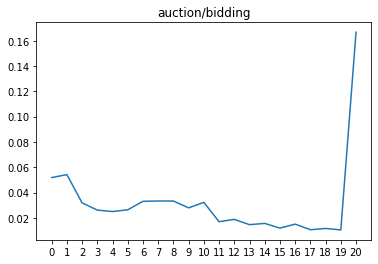

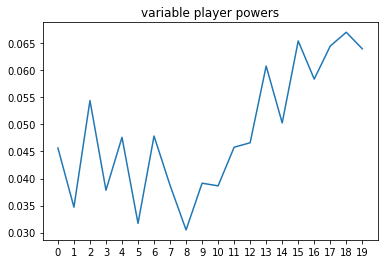

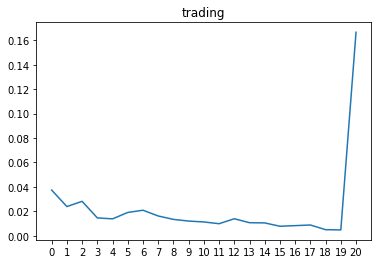

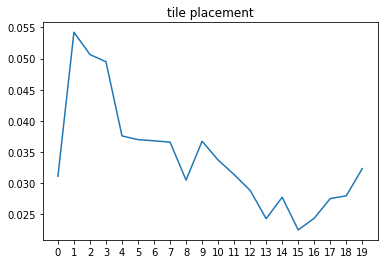

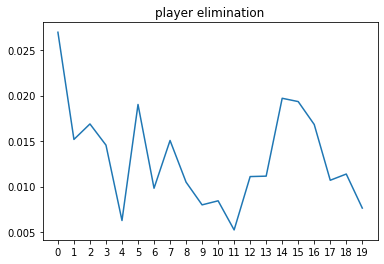

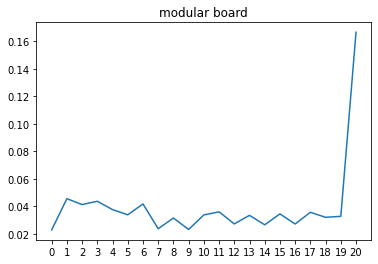

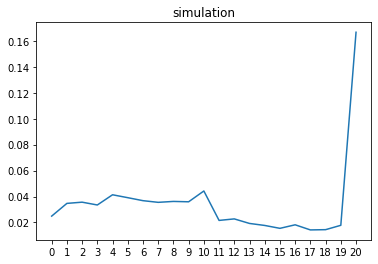

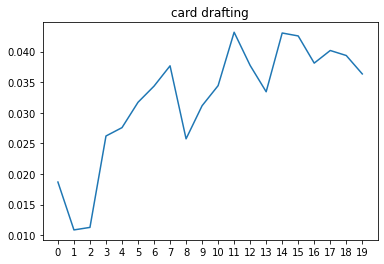

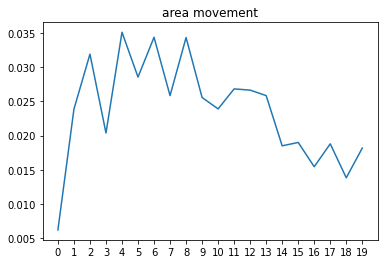

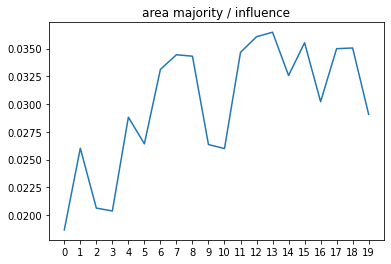

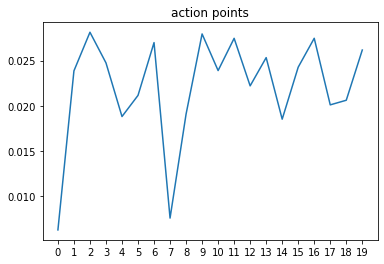

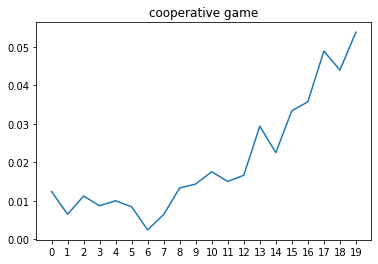

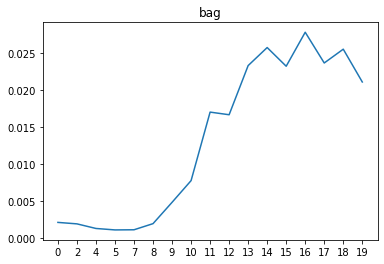

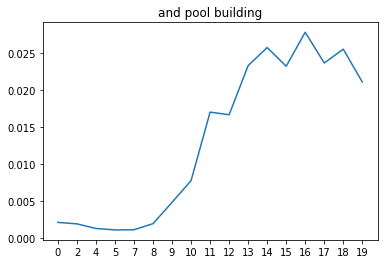

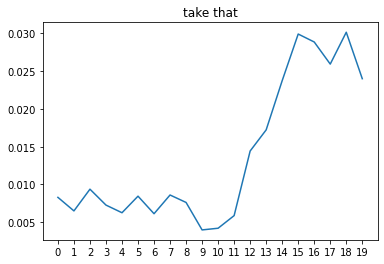

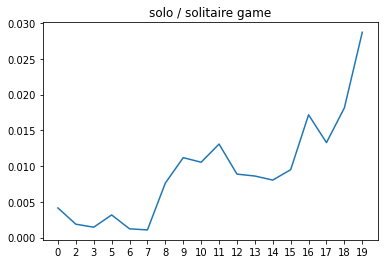

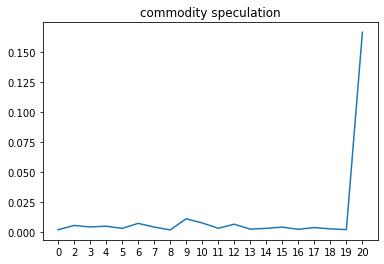

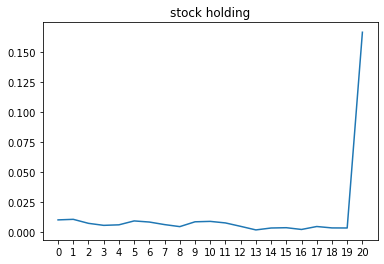

In [175]:
for graph in growth_mechs:
    label_years = [x[2] - 2000 for x in graph]
    plt.xticks(range(0, 21), label_years)
    plt.title(graph[0][1])
    plt.plot([x[0] for x in graph])
    plt.show()

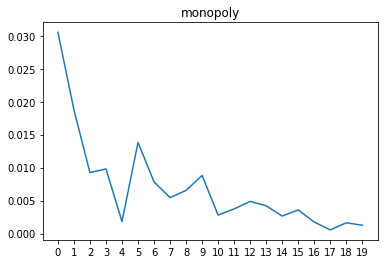

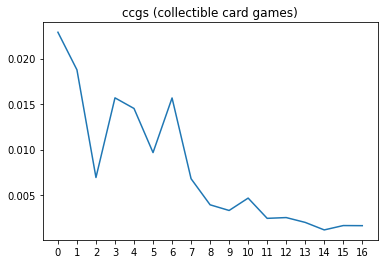

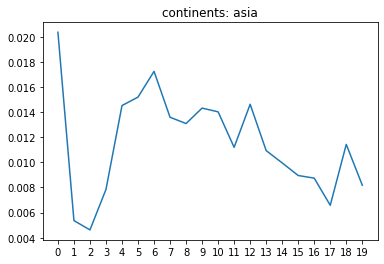

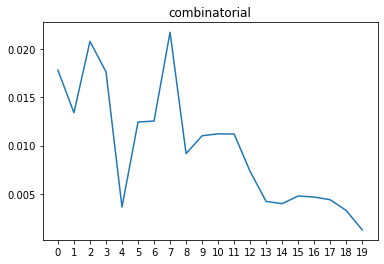

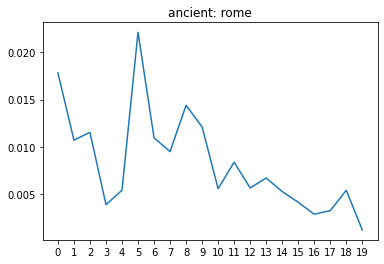

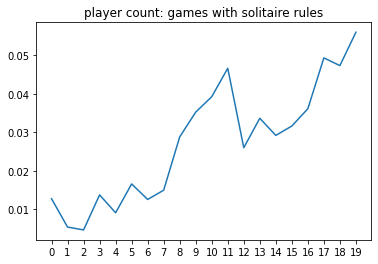

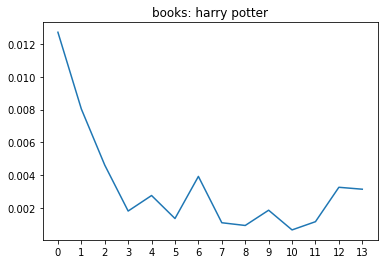

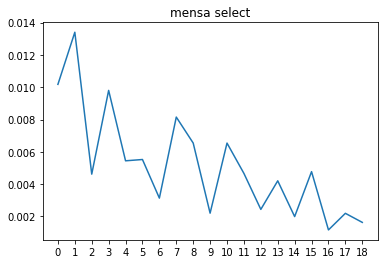

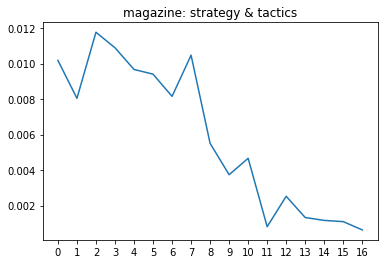

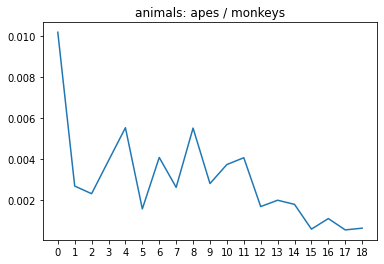

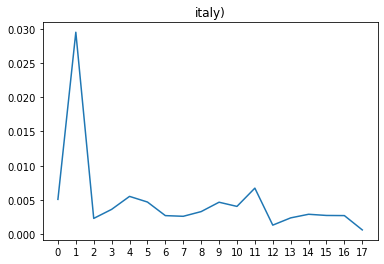

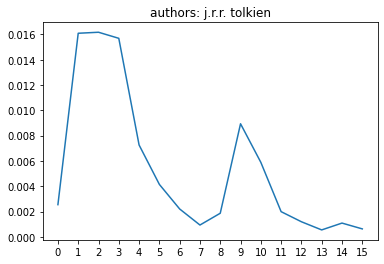

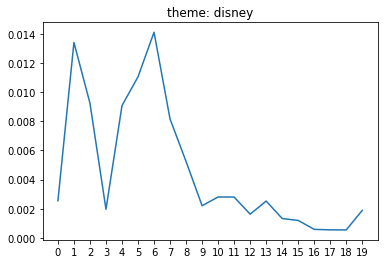

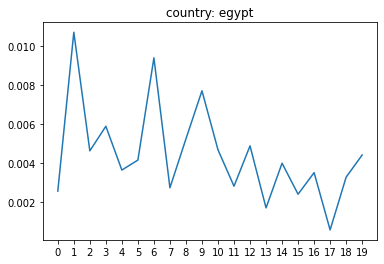

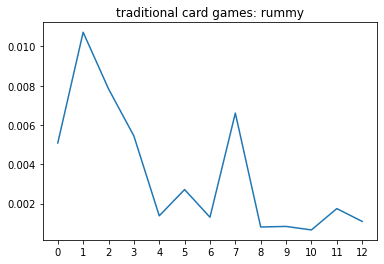

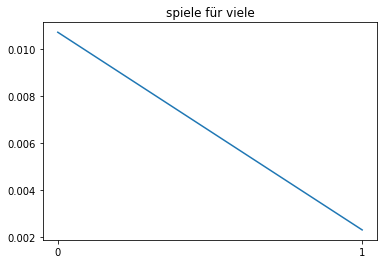

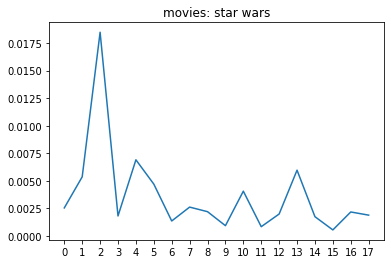

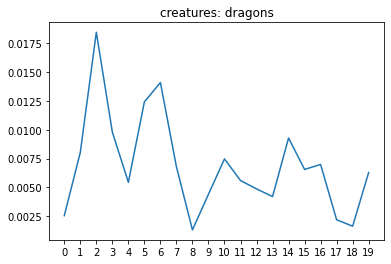

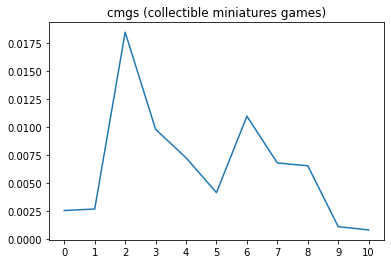

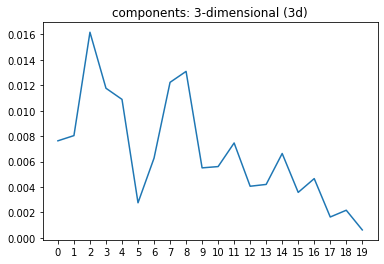

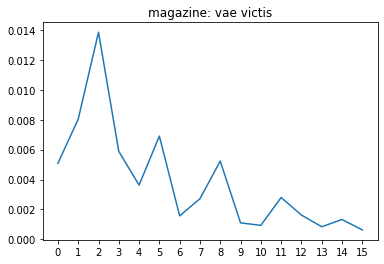

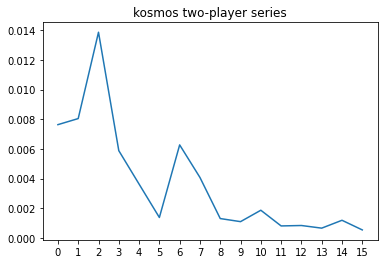

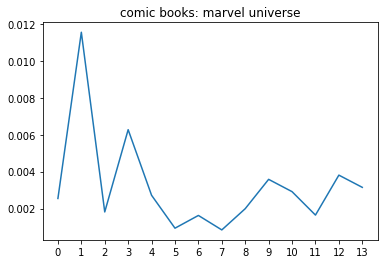

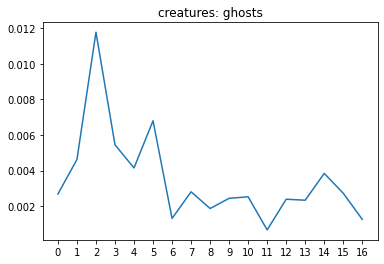

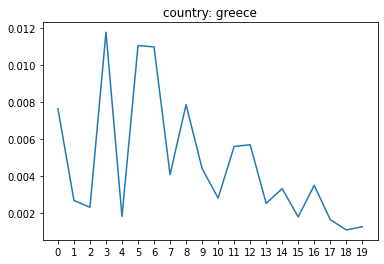

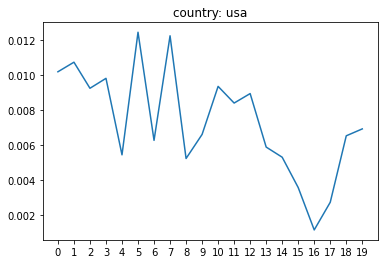

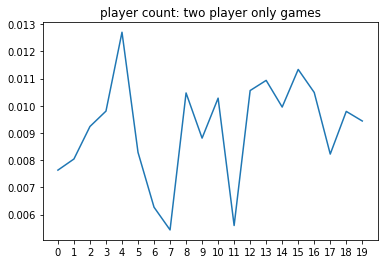

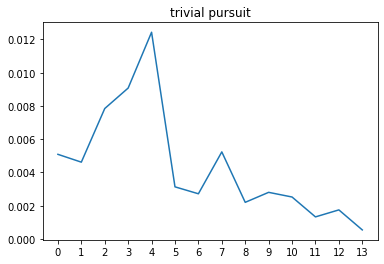

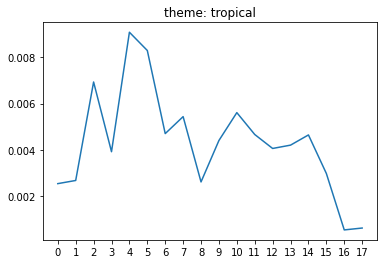

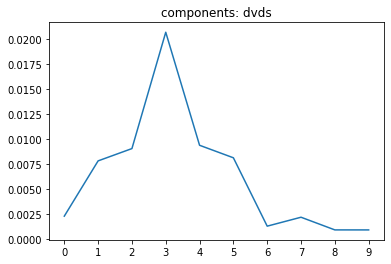

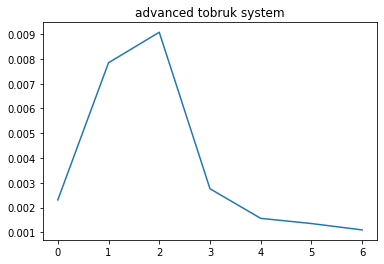

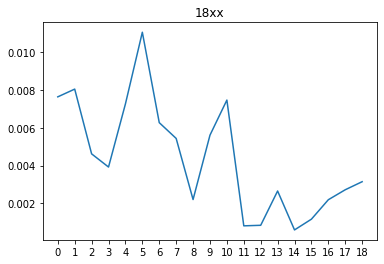

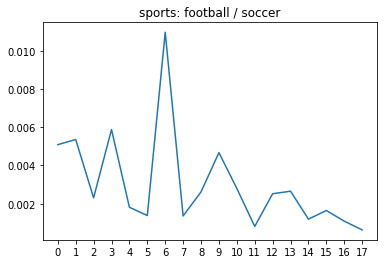

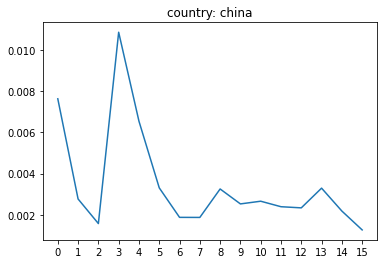

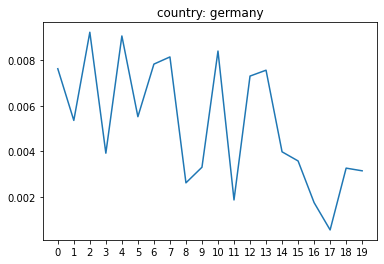

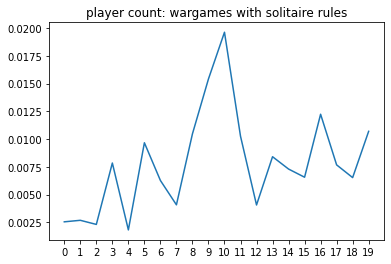

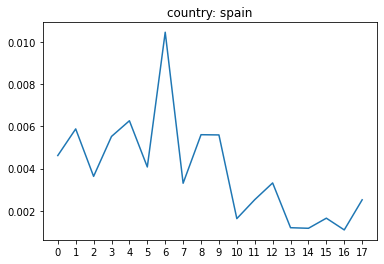

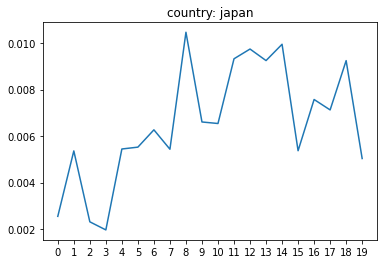

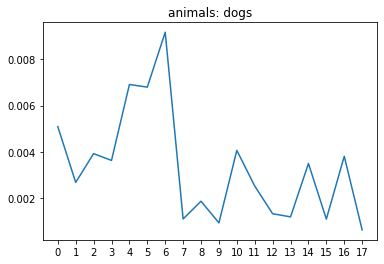

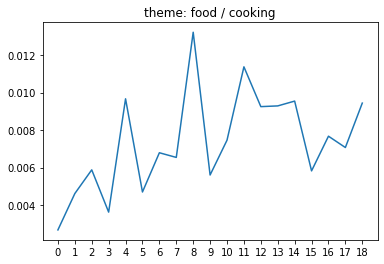

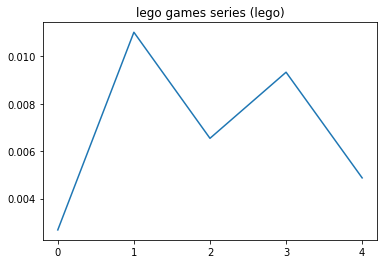

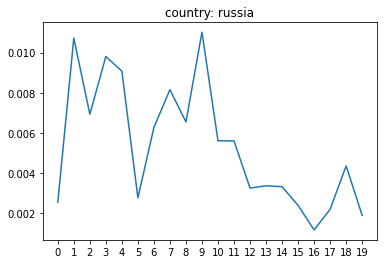

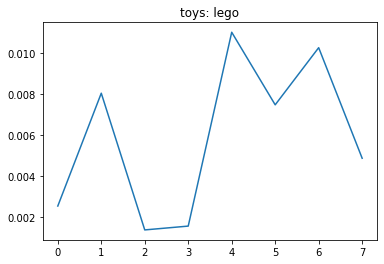

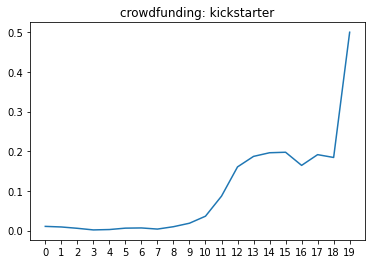

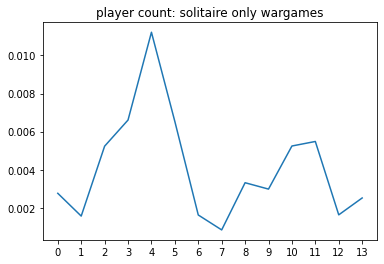

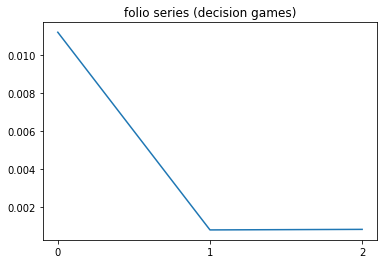

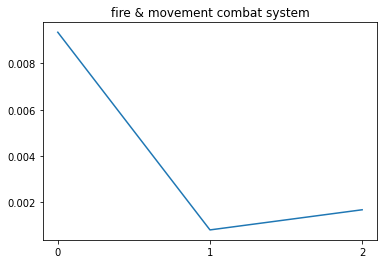

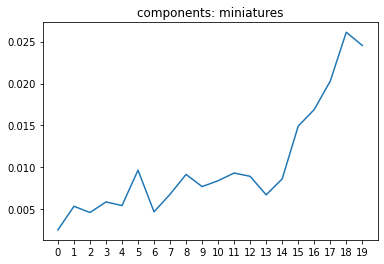

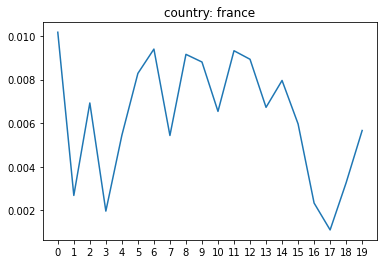

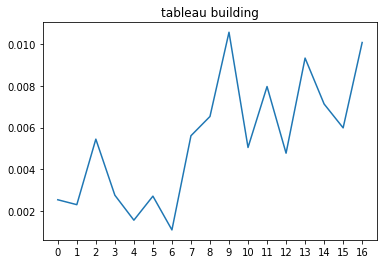

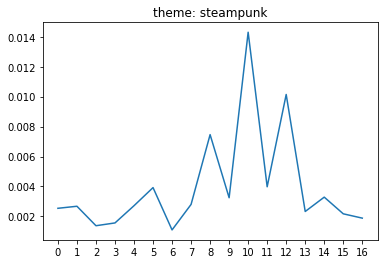

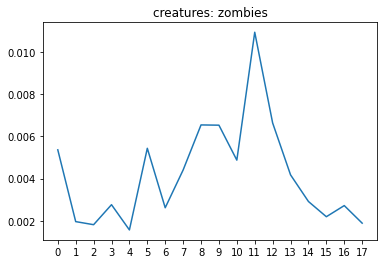

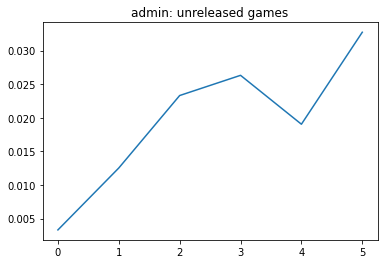

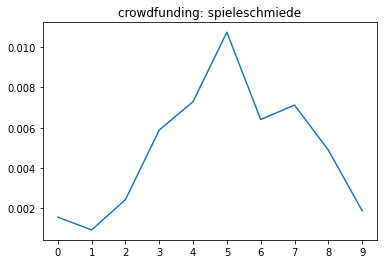

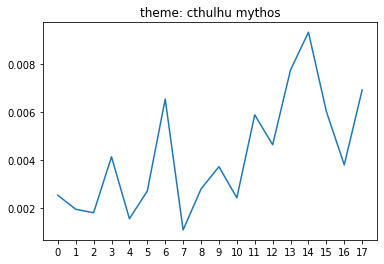

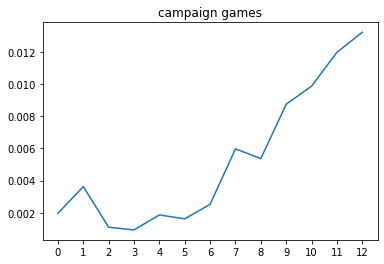

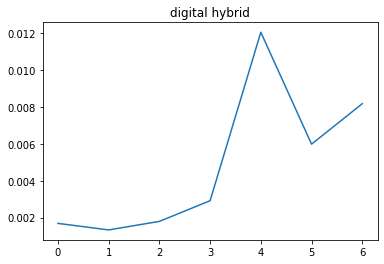

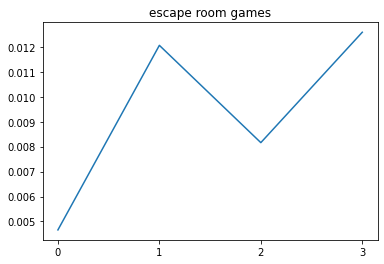

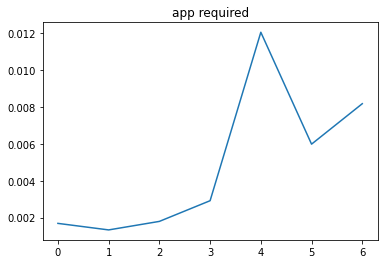

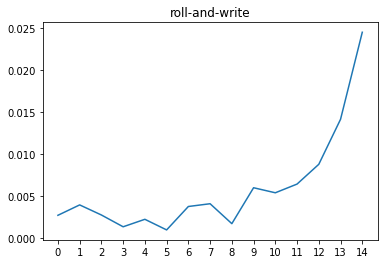

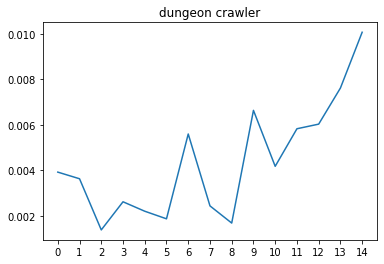

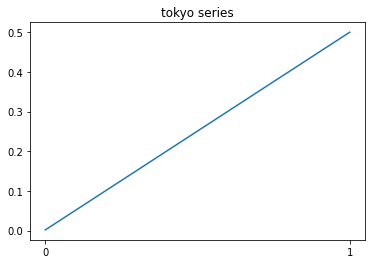

In [181]:
for graph in growth_fams:
    #label_years = [x[2] - 2000 for x in graph]
    plt.xticks(range(0, 21), [x for x in range(0, 21)])
    plt.title(graph[0][1])
    plt.plot([x[0] for x in graph])
    plt.show()

## Step 4
Include in the paper a report describing the output of Step 3